# Text classification with Unsloth

[Reference](https://github.com/timothelaborie/text_classification_scripts/blob/main/unsloth_classification.ipynb) for downloading the model.

This Unsloth notebook trains LLaMa-3 on any text classification dataset, where the input is a csv with columns "text" and "label".


### Install packages and load the model

In [1]:
# Takes several minutes first time
!pip install -q unsloth tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# needed as this function doesn't like it when the lm_head has its size changed
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc
os.environ["WANDB_DISABLED"] = "true"

max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+


# model_name = "unsloth/Qwen2-7B-bnb-4bit";load_in_4bit = True
model_name = "unsloth/llama-3-8b-bnb-4bit";load_in_4bit = True

# if no batching
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

# for batching
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load tokenizer2 FIRST, setting padding_side
tokenizer2 = AutoTokenizer.from_pretrained(
    model_name,
    padding_side="left"
)

# Set pad token if necessary (AFTER loading tokenizer)
if tokenizer2.pad_token is None:
    if tokenizer2.eos_token:
        tokenizer2.pad_token = tokenizer2.eos_token
        print(f"Set tokenizer2.pad_token to: {tokenizer2.pad_token}")
    else:
         raise ValueError("tokenizer2 lacks both pad_token and eos_token.")

# Load the model WITHOUT passing padding_side or tokenizer_kwargs related to padding
model, _ = FastLanguageModel.from_pretrained(
    model_name,
    load_in_4bit=True
)

# Prepare model for inference
FastLanguageModel.for_inference(model)

Major: 7, Minor: 5
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128255)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSN

### Making predictions

In [2]:
# Load dataset
print("Loading dataset...")

url = 'https://raw.githubusercontent.com/annakosovskaya/formality_classifier/refs/heads/main/data/formality_dataset_multi.csv'
data = pd.read_csv(url)

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

Loading dataset...


#### If we want to run the model without batching:


Evaluating 0-shot classification...


  0%|          | 0/100 [00:00<?, ?it/s]


💎 Example 1:
📜 Text: (CNN) -- A car bomb attack in Algeria has killed three people and wounded 23, the Algerian Press Service reported. An Algerian policeman stands in front of destroyed buildings in Thenia. The attack occurred Tuesday near an office housing judicial police in the city of Thenia, about 50 km (31 miles) east of the capital of Algiers, the agency said. The blast destroyed about 20 houses, and a commission has been appointed to look after the victims, the press agency said. Islamic extremists in Algeria and other North African countries have struck several times in recent years. An al Qaeda affiliate claimed responsibility last year for the deadliest attack in Algiers in 10 years, a bombing that destroyed the prime minister's headquarters and a police base, killing at least 24 people and wounding more than 220. Al Qaeda also took responsibility for a January 2 bombing that killed four and wounded 20 at a building housing security forces in Naciria, a city about 50 km (31

  0%|          | 0/100 [00:00<?, ?it/s]


💎 Example 1:
📜 Text: @user if I wanted GREEN POTATOES, a bottle with the tag still on, plus soaking wet items delivered - I'm winning today-sadly I didn't
➡️ Prompt: Task: Determine if the following texts are formal or informal.

Text: (CNN) -- A car bomb attack in Algeria has killed three people and wounded 23, the Algerian Press Service reported. An Algerian policeman stands in front of destroyed buildings in Thenia. The attack oc
Answer: formal

Text: @user if I wanted GREEN POTATOES, a bottle with the tag still on, plus soaking wet items delivered - I'm winning today-sadly I didn't
Answer:
✅ True label: informal
🗣️ Predicted: informal
🤖 Model output: informal

Text: @user I'm not sure if you're being sarcast

💎 Example 2:
📜 Text: Autocorrect changes ''em' to 'me' which I resent greatly
➡️ Prompt: Task: Determine if the following texts are formal or informal.

Text: (CNN) -- A car bomb attack in Algeria has killed three people and wounded 23, the Algerian Press Service reported. An

  0%|          | 0/100 [00:00<?, ?it/s]


💎 Example 1:
📜 Text: Autocorrect changes ''em' to 'me' which I resent greatly
➡️ Prompt: Task: Determine if the following texts are formal or informal.

Text: (CNN) -- A car bomb attack in Algeria has killed three people and wounded 23, the Algerian Press Service reported. An Algerian policeman stands in front of destroyed buildings in Thenia. The attack oc
Answer: formal

Text: @user if I wanted GREEN POTATOES, a bottle with the tag still on, plus soaking wet items delivered - I'm winning today-sadly I didn't
Answer: informal

Text: Autocorrect changes ''em' to 'me' which I resent greatly
Answer:
✅ True label: informal
🗣️ Predicted: informal
🤖 Model output: informal

Text: I'm not sure if this is the right place to

💎 Example 2:
📜 Text: COMMISSION REGULATION (EC) No 192/2005 of 3 February 2005 fixing the maximum export refund for white sugar to certain third countries for the 18th partial invitation to tender issued within the framework of the standing invitation to tender provided f

  0%|          | 0/100 [00:00<?, ?it/s]


💎 Example 1:
📜 Text: COMMISSION REGULATION (EC) No 192/2005 of 3 February 2005 fixing the maximum export refund for white sugar to certain third countries for the 18th partial invitation to tender issued within the framework of the standing invitation to tender provided for in Regulation (EC) No 1327/2004 THE COMMISSION OF THE EUROPEAN COMMUNITIES, Having regard to the Treaty establishing the European Community, Having regard to Council Regulation (EC) No 1260/2001 of 19 June 2001 on the common organisation of the markets in the sugar sector (1) and in particular the second indent of Article 27(5) thereof, Whereas: (1) Commission Regulation (EC) No 1327/2004 of 19 July 2004 on a standing invitation to tender to determine levies and/or refunds on exports of white sugar (2), for the 2004/2005 marketing year, requires partial invitations to tender to be issued for the export of this sugar to certain third countries. (2) Pursuant to Article 9(1) of Regulation (EC) No 1327/2004 a maximum e

  0%|          | 0/100 [00:00<?, ?it/s]


💎 Example 1:
📜 Text: I can't wait for you to listen to my new single 'Mystery' and my new album😋. #newmusic #newsingle #newalbum #2016 #popmusic #dark
➡️ Prompt: Task: Determine if the following texts are formal or informal.

Text: (CNN) -- A car bomb attack in Algeria has killed three people and wounded 23, the Algerian Press Service reported. An Algerian policeman stands in front of destroyed buildings in Thenia. The attack oc
Answer: formal

Text: @user if I wanted GREEN POTATOES, a bottle with the tag still on, plus soaking wet items delivered - I'm winning today-sadly I didn't
Answer: informal

Text: Autocorrect changes ''em' to 'me' which I resent greatly
Answer: informal

Text: COMMISSION REGULATION (EC) No 192/2005 of 3 February 2005 fixing the maximum export refund for white sugar to certain third countries for the 18th partial invitation to tender issued within the framew
Answer: formal

Text: I can't wait for you to listen to my new single 'Mystery' and my new album😋. #newm

  0%|          | 0/100 [00:00<?, ?it/s]


💎 Example 1:
📜 Text: Boy Scouts really fucked up. That said, I believe that their biggest mistake was not training their leaders on mandated reporting in IL. See my email below to my family members who are active scout leaders: So, through my job and internship it has come to my attention that any recreational personnel that work with children are MANDATED REPORTERS. Per the IL DCFS website at WHO ARE MANDATED REPORTERS? Members of the general public may report suspected child abuse and neglect if they choose. However, state law mandates that workers in certain professions must make reports if they have reasonable cause to suspect abuse or neglect. Mandated reporters include: Medical Personnel: Physicians, psychiatrists, surgeons, residents, interns, dentists, dentist hygienists, medical examiners, pathologists, osteopaths, coroners, Christian Science practitioners, chiropractors, podiatrists, registered and licensed practical nurses, emergency medical technicians, substance abuse tre

  0%|          | 0/100 [00:00<?, ?it/s]


💎 Example 1:
📜 Text: Following discussions with the PSNI, they will close from 16:00 -21:00 GMT on 17 March. There were a number of disturbances in the area over the St Patrick's Day holiday in 2016. In a statement, the PSNI said that the arrangement was made "to help keep people safe". Queen's University Belfast and Ulster University have also written to their students urging them not to travel to the area, or to behave responsibly if they do. Classes at both universities have been cancelled on Wednesday 15 March and Thursday 16 March. Both of those days have been designated as "reading days" for students instead. The universities will then be closed on 17 March. The chief executive of Hospitality Ulster, Colin Neill, welcomed the move by the off-licences. "I have sympathy with residents," he said, "who have been subjected to unacceptable behaviour on St Patrick's Day, year after year." "However, I also have sympathy for the local off-sales and commend them for voluntarily agreeing t

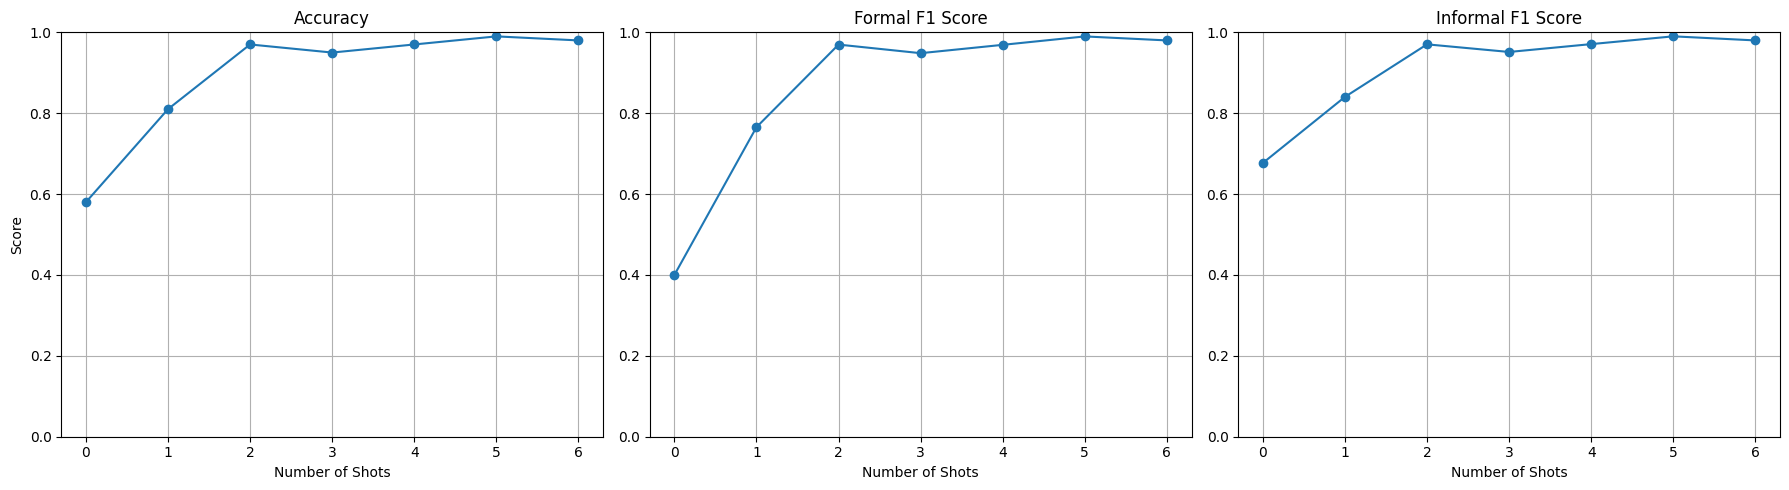


Final Results (Batched Evaluation):
0.0-shot → accuracy: 0.5800 | formal F1: 0.4000 | informal F1: 0.6769
1.0-shot → accuracy: 0.8100 | formal F1: 0.7654 | informal F1: 0.8403
2.0-shot → accuracy: 0.9700 | formal F1: 0.9697 | informal F1: 0.9703
3.0-shot → accuracy: 0.9500 | formal F1: 0.9485 | informal F1: 0.9515
4.0-shot → accuracy: 0.9700 | formal F1: 0.9691 | informal F1: 0.9709
5.0-shot → accuracy: 0.9900 | formal F1: 0.9899 | informal F1: 0.9901
6.0-shot → accuracy: 0.9800 | formal F1: 0.9800 | informal F1: 0.9800


In [5]:
def create_zero_shot_prompt(text):
    text = text[:200] if len(text) > 200 else text
    return f"""Classification task: Determine if the text is written in formal or informal language.

Text: "{text}"

Answer with ONLY ONE WORD - either "formal" or "informal":"""


def create_few_shot_prompt(text, examples):
    # Truncate text to avoid extremely long inputs
    text = text[:200] if len(text) > 200 else text

    prompt = "Task: Determine if the following texts are formal or informal.\n\n"

    for ex_text, ex_label in examples:
        # Truncate example texts as well
        ex_text = ex_text[:200] if len(ex_text) > 200 else ex_text
        prompt += f"Text: {ex_text}\nAnswer: {ex_label}\n\n"

    prompt += f"Text: {text}\nAnswer:"
    return prompt

def extract_prediction(response, is_few_shot=True):
    # Clean the response
    response = response.lower().strip()

    # First try exact matching
    if "formal" in response and "informal" not in response:
        return "formal"
    elif "informal" in response:
        return "informal"

    # # If we can't determine, look at first word
    # first_word = response.split()[0] if response.split() else ""
    # if first_word == "formal":
    #     return "formal"
    # elif first_word == "informal":
    #     return "informal"

    # Default case
    return "informal"  # Default based on dataset distribution

# Modified evaluation function with improved response handling
def evaluate_few_shot(shot_counts=[0, 5, 10], test_size=100):
    results = {}

    for num_shots in shot_counts:
        print(f"\nEvaluating {num_shots}-shot classification...")

        # Select examples for demonstration
        if num_shots > 0:
            examples = [(row['text'], row['label']) for _, row in data.head(num_shots).iterrows()]
            # Use the rest for testing
            test_data = data.iloc[num_shots:].reset_index(drop=True)
        else:
            examples = []
            test_data = data

        # Limit test size
        test_data = test_data.head(test_size)

        correct = 0
        total = 0

        # Track predictions and true labels for analysis
        all_predictions = []
        all_labels = []

        # Process examples
        for idx, row in tqdm(test_data.iterrows(), total=len(test_data)):
            # Clear cache periodically (every 10 examples to balance speed and memory)
            if idx % 10 == 0:
                torch.cuda.empty_cache()
                gc.collect()

            if num_shots > 0:
                prompt = create_few_shot_prompt(row['text'], examples)
            else:
                prompt = create_zero_shot_prompt(row['text'])

            # Tokenize
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_seq_length)
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

            # Generate response with more tokens to get a complete answer
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=15,  # Increased slightly
                    do_sample=False,
                    temperature=0.1,  # Low temperature for more deterministic answers
                )

            # Get the generated text
            full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Extract just the model's response (everything after the prompt)
            prompt_length = len(prompt)
            response = full_text[prompt_length:].strip()

            # Extract prediction
            prediction = extract_prediction(response, num_shots > 0)

            # Compare with ground truth
            if prediction == row['label']:
                correct += 1

            total += 1
            all_predictions.append(prediction)
            all_labels.append(row['label'])

            # Print examples
            if idx < 10:
                print(f"\n💎 Example {idx+1}:")
                print(f"📜 Text: {row['text']}")
                print(f"➡️ Prompt: {prompt}") # Show end of prompt
                print(f"✅ True label: {row['label']}")
                print(f"🗣️ Predicted: {prediction}")
                print(f"🤖 Model output: {response}")

        # Calculate accuracy
        accuracy = correct / total
        print(f"{num_shots}-shot accuracy: {accuracy:.4f} ({correct}/{total})")

        formal_correct = sum(1 for p, l in zip(all_predictions, all_labels) if p == l and l == "formal")
        formal_total = sum(1 for l in all_labels if l == "formal")
        informal_correct = sum(1 for p, l in zip(all_predictions, all_labels) if p == l and l == "informal")
        informal_total = sum(1 for l in all_labels if l == "informal")
        formal_predicted = sum(1 for p in all_predictions if p == "formal")
        informal_predicted = sum(1 for p in all_predictions if p == "informal")

        if formal_total > 0:
            formal_recall = formal_correct / formal_total
            print(f"Formal recall: {formal_recall:.4f} ({formal_correct}/{formal_total})")
        else:
            formal_recall = None
            print("Formal recall: N/A (0 examples)")

        if formal_predicted > 0:
            formal_precision = formal_correct / formal_predicted
            print(f"Formal precision: {formal_precision:.4f} ({formal_correct}/{formal_predicted})")
        else:
            formal_precision = None
            print("Formal precision: N/A (0 predictions)")

        if formal_total and formal_predicted:
            formal_f1 = 2 * (formal_precision * formal_recall) / (formal_precision + formal_recall)
            print(f"Formal F1: {formal_f1:.4f}")
        else:
            formal_f1 = None
            print("Formal F1: N/A (0 examples or 0 predictions)")

        if informal_total > 0:
            informal_recall = informal_correct / informal_total
            print(f"Informal recall: {informal_recall:.4f} ({informal_correct}/{informal_total})")
        else:
            informal_recall = None
            print("Informal recall: N/A (0 examples)")

        if informal_predicted > 0:
            informal_precision = informal_correct / informal_predicted
            print(f"Informal precision: {informal_precision:.4f} ({informal_correct}/{informal_predicted})")
        else:
            informal_precision = None
            print("Informal precision: N/A (0 predictions)")

        if informal_total and informal_predicted:
            informal_f1 = 2 * (informal_precision * informal_recall) / (informal_precision + informal_recall)
            print(f"Informal F1: {informal_f1:.4f}")
        else:
            informal_f1 = None
            print("Informal F1: N/A (0 examples or 0 predictions)")

        results[num_shots] = {
            "accuracy": accuracy,
            "formal_precision": formal_precision,
            "formal_recall": formal_recall,
            "formal_f1": formal_f1,
            "informal_precision": informal_precision,
            "informal_recall": informal_recall,
            "informal_f1": informal_f1,
        }

        torch.cuda.empty_cache()
        gc.collect()

    results_df = pd.DataFrame.from_dict(results, orient="index").reset_index()
    results_df = results_df.rename(columns={"index": "num_shots"})
    return results_df

results_n_df = evaluate_few_shot(shot_counts=[0, 1, 2, 3, 4, 5, 6], test_size=100)
results_n_df = results_n_df.sort_values("num_shots")

# results_n_df.to_csv("few_shot_results.csv", index=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Accuracy Plot
axes[0].plot(results_n_df["num_shots"], results_n_df["accuracy"], marker="o")
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Number of Shots")
axes[0].set_ylabel("Score")
axes[0].grid(True)
axes[0].set_ylim(0, 1)

# Formal F1 Plot
axes[1].plot(results_n_df["num_shots"], results_n_df["formal_f1"], marker="o")
axes[1].set_title("Formal F1 Score")
axes[1].set_xlabel("Number of Shots")
axes[1].grid(True)
axes[1].set_ylim(0, 1)

# Informal F1 Plot
axes[2].plot(results_n_df["num_shots"], results_n_df["informal_f1"], marker="o")
axes[2].set_title("Informal F1 Score")
axes[2].set_xlabel("Number of Shots")
axes[2].grid(True)
axes[2].set_ylim(0, 1)

# Adjust layout and save
plt.tight_layout()
plt.savefig('few_shot_metrics_batched.png')
plt.show()

# --- Print Final Results ---
print("\nFinal Results (Batched Evaluation):")
for _, row in results_n_df.iterrows():
    print(f"{row['num_shots']}-shot → "
          f"accuracy: {row['accuracy']:.4f} | "
          f"formal F1: {row['formal_f1']:.4f} | "
          f"informal F1: {row['informal_f1']:.4f}")

#### If we want to run a model with batching:


Evaluating 6-shot classification with batch_size=14...


6-shot Batches:   0%|          | 0/86 [00:00<?, ?it/s]

6-shot accuracy: 0.9640 (1151/1194)
Formal recall: 0.9415 (563/598)
Formal precision: 0.9860 (563/571)
Formal F1: 0.9632
Informal recall: 0.9866 (588/596)
Informal precision: 0.9438 (588/623)
Informal F1: 0.9647

Evaluating 5-shot classification with batch_size=14...


5-shot Batches:   0%|          | 0/86 [00:00<?, ?it/s]


💎 Example (Batch 1, Item 1):
📜 Text: Boy Scouts really fucked up. That said, I believe that their biggest mistake was not training their leaders on mandated reporting in IL. See my email below to my family members who are active scout le...
✅ True label: informal
🗣️ Predicted: informal
🤖 Model output: informal

Text: I'm not sure if this is the right place to
5-shot accuracy: 0.9598 (1147/1195)
Formal recall: 0.9498 (568/598)
Formal precision: 0.9693 (568/586)
Formal F1: 0.9595
Informal recall: 0.9698 (579/597)
Informal precision: 0.9507 (579/609)
Informal F1: 0.9602

Evaluating 4-shot classification with batch_size=14...


4-shot Batches:   0%|          | 0/86 [00:00<?, ?it/s]

4-shot accuracy: 0.9657 (1155/1196)
Formal recall: 0.9515 (569/598)
Formal precision: 0.9793 (569/581)
Formal F1: 0.9652
Informal recall: 0.9799 (586/598)
Informal precision: 0.9528 (586/615)
Informal F1: 0.9662

Evaluating 3-shot classification with batch_size=14...


3-shot Batches:   0%|          | 0/86 [00:00<?, ?it/s]

3-shot accuracy: 0.9532 (1141/1197)
Formal recall: 0.9666 (579/599)
Formal precision: 0.9415 (579/615)
Formal F1: 0.9539
Informal recall: 0.9398 (562/598)
Informal precision: 0.9656 (562/582)
Informal F1: 0.9525

Evaluating 2-shot classification with batch_size=14...


2-shot Batches:   0%|          | 0/86 [00:00<?, ?it/s]

2-shot accuracy: 0.9466 (1134/1198)
Formal recall: 0.9332 (559/599)
Formal precision: 0.9588 (559/583)
Formal F1: 0.9459
Informal recall: 0.9599 (575/599)
Informal precision: 0.9350 (575/615)
Informal F1: 0.9473

Evaluating 1-shot classification with batch_size=14...


1-shot Batches:   0%|          | 0/86 [00:00<?, ?it/s]

1-shot accuracy: 0.8465 (1015/1199)
Formal recall: 0.6962 (417/599)
Formal precision: 0.9952 (417/419)
Formal F1: 0.8193
Informal recall: 0.9967 (598/600)
Informal precision: 0.7667 (598/780)
Informal F1: 0.8667

Evaluating 0-shot classification with batch_size=14...


0-shot Batches:   0%|          | 0/86 [00:00<?, ?it/s]


💎 Example (Batch 1, Item 1):
📜 Text: (CNN) -- A car bomb attack in Algeria has killed three people and wounded 23, the Algerian Press Service reported. An Algerian policeman stands in front of destroyed buildings in Thenia. The attack oc...
✅ True label: formal
🗣️ Predicted: informal
🤖 Model output: informal
0-shot accuracy: 0.6267 (752/1200)
Formal recall: 0.2867 (172/600)
Formal precision: 0.8958 (172/192)
Formal F1: 0.4343
Informal recall: 0.9667 (580/600)
Informal precision: 0.5754 (580/1008)
Informal F1: 0.7214


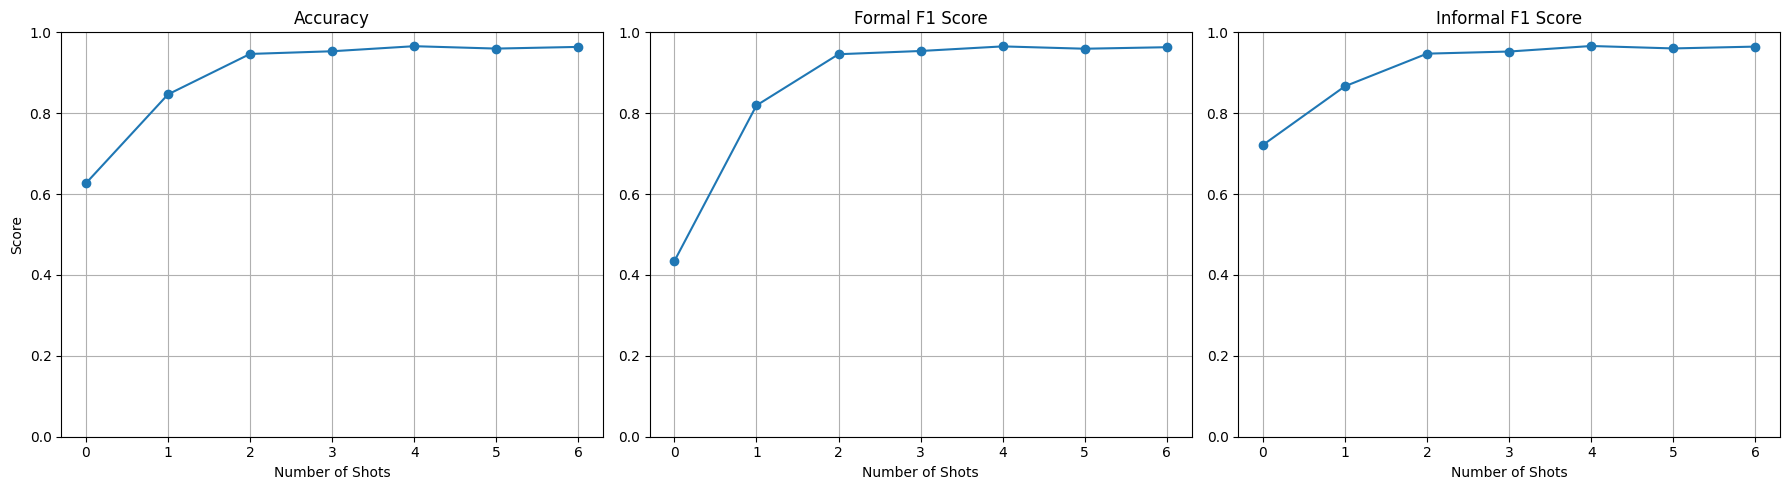


Final Results (Batched Evaluation):
0.0-shot → accuracy: 0.6267 | formal F1: 0.4343 | informal F1: 0.7214
1.0-shot → accuracy: 0.8465 | formal F1: 0.8193 | informal F1: 0.8667
2.0-shot → accuracy: 0.9466 | formal F1: 0.9459 | informal F1: 0.9473
3.0-shot → accuracy: 0.9532 | formal F1: 0.9539 | informal F1: 0.9525
4.0-shot → accuracy: 0.9657 | formal F1: 0.9652 | informal F1: 0.9662
5.0-shot → accuracy: 0.9598 | formal F1: 0.9595 | informal F1: 0.9602
6.0-shot → accuracy: 0.9640 | formal F1: 0.9632 | informal F1: 0.9647


In [6]:
import pandas as pd
import torch
import gc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from unsloth import FastLanguageModel

max_seq_length = 512

# --- Prompt creation and prediction extraction functions ---
def create_zero_shot_prompt(text):
    text = text[:200] if len(text) > 200 else text
    return f"""Classification task: Determine if the text is written in formal or informal language.

Text: "{text}"

Answer with ONLY ONE WORD - either "formal" or "informal":"""

def create_few_shot_prompt(text, examples):
    text = text[:200] if len(text) > 200 else text
    prompt = "Task: Determine if the following texts are formal or informal.\n\n"
    for ex_text, ex_label in examples:
        ex_text = ex_text[:200] if len(ex_text) > 200 else ex_text
        prompt += f"Text: {ex_text}\nAnswer: {ex_label}\n\n"
    prompt += f"Text: {text}\nAnswer:"
    return prompt

def extract_prediction(response, is_few_shot=True):
    response = response.lower().strip()
    # Prioritize exact match at the beginning of the response
    if response.startswith("formal"):
        return "formal"
    elif response.startswith("informal"):
        return "informal"
    # Fallback to checking within the response
    elif "formal" in response and "informal" not in response:
        return "formal"
    elif "informal" in response:
        return "informal"
    return "informal" # Default

# --- Evaluation function with BATCHING ---
@torch.inference_mode()
def evaluate_few_shot_batched(shot_counts=[0, 5, 10], test_size=100, batch_size=8):
    results = {}
    # tokenizer2 for batching
    if tokenizer2.pad_token is None:
        print("Setting pad_token to eos_token for tokenizer2")
        if tokenizer2.eos_token:
             tokenizer2.pad_token = tokenizer2.eos_token # Important for batching
             print(f"Set tokenizer2.pad_token to: {tokenizer2.pad_token}")
        else:
             # Handle error: Cannot set pad_token if eos_token is also missing
             raise ValueError("tokenizer2 is missing eos_token, cannot set pad_token automatically.")


    for num_shots in shot_counts:
        print(f"\nEvaluating {num_shots}-shot classification with batch_size={batch_size}...")

        # Select examples for demonstration
        if num_shots > 0:
            examples = [(row['text'], row['label']) for _, row in data.head(num_shots).iterrows()]
            test_data_full = data.iloc[num_shots:].reset_index(drop=True)
        else:
            examples = []
            test_data_full = data

        # Limit test size
        test_data = test_data_full.head(test_size)

        correct = 0
        total = 0
        all_predictions = []
        all_labels = []

        # Process data in batches
        for i in tqdm(range(0, len(test_data), batch_size), desc=f"{num_shots}-shot Batches"):
            batch_df = test_data.iloc[i : i + batch_size]
            batch_texts = batch_df['text'].tolist()
            batch_true_labels = batch_df['label'].tolist()

            # Create prompts for the batch
            if num_shots > 0:
                batch_prompts = [create_few_shot_prompt(text, examples) for text in batch_texts]
            else:
                batch_prompts = [create_zero_shot_prompt(text) for text in batch_texts]

            # --- Batch Tokenization ---
            # Use tokenizer2 here
            inputs = tokenizer2(
                batch_prompts,
                return_tensors="pt",
                padding=True,         # Pad sequences to the longest in the batch
                truncation=True,
                max_length=max_seq_length - 15, # Reserve space for generation
                # padding_side should be implicitly handled by tokenizer2 setting
            ).to("cuda")

            # --- Batch Generation ---
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=15,
                do_sample=False,
                temperature=0.1,
                pad_token_id=tokenizer2.pad_token_id
            )

            # --- Batch Decoding ---
            # Decode only the generated part (relative to the input length)
            batch_responses = []
            for idx in range(len(batch_prompts)):
                # Need input length based on padded input tokens from tokenizer2
                input_length = inputs["input_ids"][idx].shape[0]

                # Decode generated tokens for this specific example
                # Use tokenizer2 here
                generated_tokens = outputs[idx][input_length:]
                response = tokenizer2.decode(generated_tokens, skip_special_tokens=True).strip()
                batch_responses.append(response)


            # --- Process Batch Results ---
            for idx in range(len(batch_prompts)):
                prompt = batch_prompts[idx]
                response = batch_responses[idx]
                true_label = batch_true_labels[idx]

                prediction = extract_prediction(response, num_shots > 0)

                if prediction == true_label:
                    correct += 1

                total += 1
                all_predictions.append(prediction)
                all_labels.append(true_label)

                # Print first example of the first batch
                if i == 0 and idx == 0 and num_shots in [0, 5]: # Print example for 0 and 5 shots
                    print(f"\n💎 Example (Batch 1, Item 1):")
                    print(f"📜 Text: {batch_texts[idx][:200]}...") # Show truncated text
                    # print(f"➡️ Prompt: {prompt}")
                    print(f"✅ True label: {true_label}")
                    print(f"🗣️ Predicted: {prediction}")
                    print(f"🤖 Model output: {response}")

            # --- Clear Cache ---
            del inputs, outputs
            torch.cuda.empty_cache()
            # gc.collect()

        # --- Calculate Metrics for this num_shots ---
        if total == 0:
             print(f"{num_shots}-shot accuracy: N/A (No examples processed)")
             results[num_shots] = 0.0
             continue

        accuracy = correct / total
        print(f"{num_shots}-shot accuracy: {accuracy:.4f} ({correct}/{total})")

        formal_correct = sum(1 for p, l in zip(all_predictions, all_labels) if p == l and l == "formal")
        formal_total = sum(1 for l in all_labels if l == "formal")
        informal_correct = sum(1 for p, l in zip(all_predictions, all_labels) if p == l and l == "informal")
        informal_total = sum(1 for l in all_labels if l == "informal")
        formal_predicted = sum(1 for p in all_predictions if p == "formal")
        informal_predicted = sum(1 for p in all_predictions if p == "informal")

        if formal_total > 0:
            formal_recall = formal_correct / formal_total
            print(f"Formal recall: {formal_recall:.4f} ({formal_correct}/{formal_total})")
        else:
             print("Formal recall: N/A (0 examples)")
        if formal_predicted > 0:
            formal_precision = formal_correct / formal_predicted
            print(f"Formal precision: {formal_precision:.4f} ({formal_correct}/{formal_predicted})")
        else:
            print("Formal precision: N/A (0 predictions)")

        if formal_predicted > 0 and formal_total > 0:
            formal_f1 = 2 * (formal_precision * formal_recall) / (formal_precision + formal_recall)
            print(f"Formal F1: {formal_f1:.4f}")
        else:
            print("Formal F1: N/A (0 examples or 0 predictions)")

        if informal_total > 0:
            informal_recall = informal_correct / informal_total
            print(f"Informal recall: {informal_recall:.4f} ({informal_correct}/{informal_total})")
        else:
            print("Informal recall: N/A (0 examples)")

        if informal_predicted > 0:
            informal_precision = informal_correct / informal_predicted
            print(f"Informal precision: {informal_precision:.4f} ({informal_correct}/{informal_predicted})")
        else:
            print("Informal precision: N/A (0 predictions)")

        if informal_predicted > 0 and informal_total > 0:
            informal_f1 = 2 * (informal_precision * informal_recall) / (informal_precision + informal_recall)
            print(f"Informal F1: {informal_f1:.4f}")
        else:
            print("Informal F1: N/A (0 examples or 0 predictions)")

        # results[num_shots] = accuracy
        results[num_shots] = {
            "accuracy": accuracy,
            "formal_precision": formal_precision if formal_predicted > 0 else None,
            "formal_recall": formal_recall if formal_total > 0 else None,
            "formal_f1": formal_f1 if formal_predicted > 0 and formal_total > 0 else None,
            "informal_precision": informal_precision if informal_predicted > 0 else None,
            "informal_recall": informal_recall if informal_total > 0 else None,
            "informal_f1": informal_f1 if informal_predicted > 0 and informal_total > 0 else None,
        }

        # Clear memory before moving to next shot count
        torch.cuda.empty_cache()
        # gc.collect()

    results_df = pd.DataFrame.from_dict(results, orient="index").reset_index()
    results_df = results_df.rename(columns={"index": "num_shots"})

    return results_df

# --- Run Evaluations ---
results_df = evaluate_few_shot_batched(
    shot_counts=[6, 5, 4, 3, 2, 1, 0],
    test_size=3000,
    batch_size=14
)

# Sort by number of shots to ensure correct plotting
results_df = results_df.sort_values("num_shots")

# Create 3 side-by-side plots: Accuracy, Formal F1, Informal F1
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Accuracy Plot
axes[0].plot(results_df["num_shots"], results_df["accuracy"], marker="o")
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Number of Shots")
axes[0].set_ylabel("Score")
axes[0].grid(True)
axes[0].set_ylim(0, 1)

# Formal F1 Plot
axes[1].plot(results_df["num_shots"], results_df["formal_f1"], marker="o")
axes[1].set_title("Formal F1 Score")
axes[1].set_xlabel("Number of Shots")
axes[1].grid(True)
axes[1].set_ylim(0, 1)

# Informal F1 Plot
axes[2].plot(results_df["num_shots"], results_df["informal_f1"], marker="o")
axes[2].set_title("Informal F1 Score")
axes[2].set_xlabel("Number of Shots")
axes[2].grid(True)
axes[2].set_ylim(0, 1)

# Adjust layout and save
plt.tight_layout()
plt.savefig('few_shot_metrics_batched.png')
plt.show()

# --- Print Final Results ---
print("\nFinal Results (Batched Evaluation):")
for _, row in results_df.iterrows():
    print(f"{row['num_shots']}-shot → "
          f"accuracy: {row['accuracy']:.4f} | "
          f"formal F1: {row['formal_f1']:.4f} | "
          f"informal F1: {row['informal_f1']:.4f}")

In [7]:
results_df.to_csv("few_shot_results.csv", index=False)
print("Saved evaluation results to few_shot_results.csv")

Saved evaluation results to few_shot_results.csv
